# stencilgen pred verification

In [1]:
import sys
sys.path.insert(0, '..')

import pycuda.autoinit
import pycuda.driver as drv
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

import measure_metric.measureMetric as measureMetric

from stencilgen.stencil import *
from tsmgen.kernel import *
import stencilgen.bench as stencilbench
import tsmgen.benchmark as tsmbench
from predict import *

#% matplotlib notebook

In [2]:
%load_ext autoreload
%autoreload 1
%aimport stencilgen.stencil
%aimport stencilgen.bench
%aimport predict
%aimport griditeration

In [3]:
storeVolumes = []
loadVolumes = []
for r in range(0, 10):
    kernel = Kernel2DBoxStencil(stencil_range=r, l1only=False)
    

    block = (32, 8, 1)
    grid = kernel.getGrid(1, block, 15000, 15000)
    concurrentGrid = getConcurrentGrid(getBlocksPerSM(block, 32)*80, grid)
    truncatedConcurrentGrid = tuple(min(4, c) for c in concurrentGrid)

    print(concurrentGrid)
    print(truncatedConcurrentGrid)
    
    measureMetric.measureBandwidthStart()    
    stencilbench.runKernel(kernel, kernel.getGrid(1, block, 15000, 15000), block)
    result = measureMetric.measureMetricStop()
    
    storeVolumes.append(result[1])
    loadVolumes.append(result[0])
    
    L2LoadBlockVolume = getL2LoadBlockVolume(block, truncatedConcurrentGrid, kernel.genLoads())
    L2StoreBlockVolume = getL2StoreBlockVolume(block, truncatedConcurrentGrid, kernel.genStores())

    memLoadBlockVolume = getMemLoadBlockVolume(block, concurrentGrid, kernel.genLoads())
    memStoreBlockVolume = getMemStoreBlockVolume(block, concurrentGrid, kernel.genStores())

    L1Cycles = getL1Cycles(block, truncatedConcurrentGrid, {**kernel.genLoads(), ** kernel.genStores()})
    
    print("mem load:  {:7.3f} {:7.3f}".format(result[0] / 15000**2, memLoadBlockVolume / block[0] / block[1] / block[2]))
    print("mem store: {:7.3f} {:7.3f}".format(result[1] / 15000**2, memStoreBlockVolume / block[0] / block[1] / block[2]))
    print("L2 load:   {:7.3f} {:7.3f}".format(result[2]*32 / 15000**2, L2LoadBlockVolume / block[0] / block[1] / block[2]))
    print("L2 store:  {:7.3f} {:7.3f}".format(result[3]*32 / 15000**2, L2StoreBlockVolume / block[0] / block[1] / block[2]))
    print("L1 cycles: {:7.3f} ".format(L1Cycles))
    print()

(469, 2, 1)
(4, 2, 1)
mem load:    8.000   7.996
mem store:   7.986   7.996
L2 load:     8.000   8.000
L2 store:    8.000   8.000
L1 cycles:   4.000 

(469, 2, 1)
(4, 2, 1)
mem load:    8.005   8.996
mem store:   7.985   7.996
L2 load:    12.460  12.500
L2 store:    8.003   8.000
L1 cycles:  20.000 

(469, 2, 1)
(4, 2, 1)
mem load:    8.004   9.995
mem store:   7.985   7.996
L2 load:    14.893  15.000
L2 store:    8.002   8.000
L1 cycles:  52.000 

(469, 2, 1)
(4, 2, 1)
mem load:    8.004  10.995
mem store:   7.984   7.996
L2 load:    17.382  17.500
L2 store:    8.001   8.000
L1 cycles: 100.000 

(469, 2, 1)
(4, 2, 1)
mem load:    8.000  11.994
mem store:   7.979   7.996
L2 load:    19.840  20.000
L2 store:    7.991   8.000
L1 cycles: 164.000 

(469, 2, 1)
(4, 2, 1)
mem load:    8.004  12.994
mem store:   7.978   7.996
L2 load:    26.592  27.000
L2 store:    7.995   8.000
L1 cycles: 244.000 

(469, 2, 1)
(4, 2, 1)
mem load:    8.005  13.993
mem store:   7.978   7.996
L2 load:    29.485

In [4]:
def compareSeries( xblocks, yblocks, ranges, version=2, overlap=randomOverlap, **stencilArgs):
    best_values = []

    measuredValues = []
    predictedValues = []
   
    xtickCounter = 0
    xticks = []
    xtickLabels = []

    
    for r in ranges:
        kernel = Kernel2DBoxStencil(stencil_range=r, **stencilArgs)
    
        for xblock in xblocks:
            
            newXtick = xtickCounter
            for yblock in yblocks:
                if xblock*yblock > 1024 or xblock*yblock < 32:
                    continue

                block = (xblock, yblock, 1)

                print("r={}, block={}x{}".format(r, xblock, yblock))
                if newXtick == xtickCounter:
                    newLabel = "r={};{}x{}".format(r, xblock, yblock)
                measuredValues.append( stencilbench.benchKernel(kernel, 11, (xblock, yblock, 1))[2])
                if version == 1:
                    predictedValues.append(predictPerformanceV1(kernel, block, (16,16,1), 32) )
                else:
                    predictedValues.append(predictPerformance(kernel, block, (32,16,1), overlap=overlap) * kernel.flops)
                print("Meas / Pred (GFlop/s): {:.0f} / {:.0f}".format( measuredValues[-1], predictedValues[-1]))
                print()
                xtickCounter += 1
                
            if newXtick != xtickCounter:
                xticks.append(newXtick)
                xtickLabels.append(newLabel)        

        print()
    return measuredValues, predictedValues, xticks, xtickLabels

def plotComparison(measuredValues, predictedValues, xticks, xtickLabels):
   
    fig, ax = plt.subplots()
    fig.set_figwidth(9)
    fig.set_figheight(4.5)
    fig.set_dpi(200)

    ax.plot(predictedValues, "-+", label="predicted",  color="#CCE699", linewidth=3, markersize=9, markeredgewidth=2, markeredgecolor="#B5CC88")
    ax.plot(measuredValues, "-x", label="measured", color="#99B3E6", linewidth=3, markersize=7, markeredgewidth=2, markeredgecolor="#889FCC")

    #ax.set_yscale("log")

    ax.set_xticks(xticks)
    ax.set_xticklabels( xtickLabels, rotation=60, rotation_mode="anchor", horizontalalignment="right")
    ax.set_ylim(0, ax.get_ylim()[1])
    ax.set_xlim(-1, len(predictedValues))

    #fig.tight_layout()
    ax.legend()
    ax.grid()
    plt.show()


In [32]:
l1data = compareSeries([1, 2, 4, 8, 16, 32, 64, 128], [8, 16, 32, 64, 128, 256, 512], [1], l1only=True)

r=1, block=1x32
(32, 16, 1)
(1, 32, 1)
(32, 16, 1)
(4, 4, 1)
51.0
0.0
144.0 cycles
1.2890625
0.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       5120   480    4608    72      268    2442  12918
       5120   120     514    72      210     237   6201
Meas / Pred (GFlop/s): 141 / 164

r=1, block=1x64
(32, 16, 1)
(1, 64, 1)
(32, 16, 1)
(4, 4, 1)
49.5
0.0
144.0 cycles
0.64453125
0.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       5120   960    9216   144      268    4700  20264
       5120   120    3744    72      210     241   9435
Meas / Pred (GFlop/s): 140 / 216

r=1, block=1x128
(32, 16, 1)
(1, 128, 1)
(32, 16, 1)
(4, 4, 1)
24.75
0.0
144.0 cycles
0.322265625
0.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       2560   960    9216   144      213    2371  15320
       2560   120    6162    72      210     237   9289
Meas / Pred (GFlop/s): 139 / 219

r=1, block=1x256
(32, 16, 1)
(1, 256, 1)
(32, 16, 1)
(4, 4, 1)
12.375
0.0
144.0 cycles
0.16113281

18.0 cycles
0.43828125
0.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        640   960    1152   144      232    1101   4085
        640   126      98    82      210     315   1389
Meas / Pred (GFlop/s): 1239 / 1465

r=1, block=32x32
(32, 16, 1)
(32, 32, 1)
(32, 5, 1)
(4, 4, 1)
10.625
0.0
18.0 cycles
0.43828125
0.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        320   960    1152   144      232    1042   3706
        320   133     224    86      210     346   1233
Meas / Pred (GFlop/s): 1198 / 1650

r=1, block=64x8
(32, 16, 1)
(64, 8, 1)
(32, 10, 1)
(4, 4, 1)
11.25
0.0
18.0 cycles
0.43828125
0.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        640   960    1152   144      232    1101   4085
        640   126      98    82      210     315   1389
Meas / Pred (GFlop/s): 1233 / 1465

r=1, block=64x16
(32, 16, 1)
(64, 16, 1)
(32, 5, 1)
(4, 4, 1)
10.125
0.0
18.0 cycles
0.43828125
0.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       

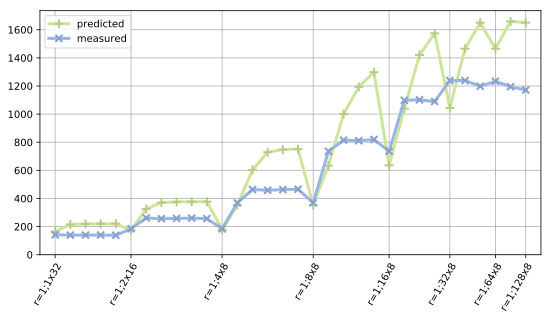

In [33]:
plotComparison(*l1data)

In [34]:
memdata = compareSeries([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024], [1, 2, 4, 8, 16, 32, 64, 128, 256], [1, 2, 3])

r=1, block=1x32
(32, 16, 1)
(1, 32, 1)
(32, 16, 1)
(4, 4, 1)
51.0
32.0
160.0 cycles
10.0390625
8.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       5120   480    5120    72     2604    3947  17271
       5120   120     705    72      210     262   6417
Meas / Pred (GFlop/s): 98 / 159

r=1, block=1x64
(32, 16, 1)
(1, 64, 1)
(32, 16, 1)
(4, 4, 1)
49.5
32.0
160.0 cycles
10.01953125
8.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       5120   960   10240   144     5248    7710  29278
       5120   120    4673    72      223     302  10437
Meas / Pred (GFlop/s): 101 / 195

r=1, block=1x128
(32, 16, 1)
(1, 128, 1)
(32, 16, 1)
(4, 4, 1)
48.75
32.0
160.0 cycles
10.009765625
8.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       2560   960   10240   144     5245    7640  26644
       2560   120    7106    72      224     303  10312
Meas / Pred (GFlop/s): 97 / 197

r=1, block=1x256
(32, 16, 1)
(1, 256, 1)
(32, 16, 1)
(4, 4, 1)
48.375
32.0
160.0 cycles
10.00

9.0703125
8.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       5120   480     640    72     2461    1830  10532
       5120   120      22    72      211     237   5760
Meas / Pred (GFlop/s): 184 / 177

r=1, block=32x2
(32, 16, 1)
(32, 2, 1)
(32, 16, 1)
(4, 4, 1)
20.0
8.0
20.0 cycles
8.56640625
8.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       5120   960    1280   144     4821    2677  14858
       5120   120      25    73      317     237   5866
Meas / Pred (GFlop/s): 366 / 347

r=1, block=32x4
(32, 16, 1)
(32, 4, 1)
(32, 16, 1)
(4, 4, 1)
15.0
8.0
20.0 cycles
8.314453125
8.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       2560   960    1280   144     4747    2207  11753
       2560   120      27    73     1676     237   4666
Meas / Pred (GFlop/s): 429 / 436

r=1, block=32x8
(32, 16, 1)
(32, 8, 1)
(32, 16, 1)
(4, 4, 1)
12.5
8.0
20.0 cycles
8.1884765625
8.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       1280   960    1280   14

       2560   120   11527   202      210     237  14654
Meas / Pred (GFlop/s): 242 / 386

r=2, block=2x128
(32, 16, 1)
(2, 128, 1)
(32, 16, 1)
(4, 4, 1)
33.0
16.0
228.0 cycles
9.017578125
8.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       1280   960   14592   400     4953    4653  26438
       1280   120   12778   202      210     237  14625
Meas / Pred (GFlop/s): 238 / 386

r=2, block=2x256
(32, 16, 1)
(2, 256, 1)
(32, 10, 1)
(4, 4, 1)
32.5
16.0
228.0 cycles
9.0140625
8.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        640   960   14592   400     4952    4606  25750
        640   120   13406   202      210     237  14613
Meas / Pred (GFlop/s): 234 / 387

r=2, block=4x8
(32, 16, 1)
(4, 8, 1)
(32, 16, 1)
(4, 4, 1)
36.0
8.0
124.0 cycles
8.765625
8.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       5120   480    3968   200     2417    2112  14097
       5120   120     342   202      210     237   6029
Meas / Pred (GFlop/s): 405 / 469

r=2, blo

9.03515625
8.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       2560   960    3328   400     4958    3336  15142
       2560   120     159   217     1696     280   4874
Meas / Pred (GFlop/s): 942 / 1160

r=2, block=64x4
(32, 16, 1)
(64, 4, 1)
(32, 16, 1)
(4, 4, 1)
18.0
8.0
52.0 cycles
8.533203125
8.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       1280   960    3328   400     4811    2489  12868
       1280   120     165   218     2919     244   4782
Meas / Pred (GFlop/s): 965 / 1182

r=2, block=64x8
(32, 16, 1)
(64, 8, 1)
(32, 10, 1)
(4, 4, 1)
13.5
8.0
52.0 cycles
8.4328125
8.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        640   960    3328   400     4781    2065  11775
        640   120     166   218     3551     237   4766
Meas / Pred (GFlop/s): 984 / 1186

r=2, block=64x16
(32, 16, 1)
(64, 16, 1)
(32, 5, 1)
(4, 4, 1)
11.25
8.0
52.0 cycles
8.4328125
8.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        320   960    3328   

        640   120   14301   405      210     237  15508
Meas / Pred (GFlop/s): 457 / 714

r=3, block=4x256
(32, 16, 1)
(4, 256, 1)
(32, 5, 1)
(4, 4, 1)
24.5625
8.0
242.0 cycles
8.53984375
8.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        320   960   15488   784     4813    3106  24687
        320   120   14616   405      210     237  15503
Meas / Pred (GFlop/s): 448 / 715

r=3, block=8x4
(32, 16, 1)
(8, 4, 1)
(32, 16, 1)
(4, 4, 1)
40.0
8.0
142.0 cycles
9.0234375
8.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       5120   480    4544   392     2455    2301  14899
       5120   120     493   408      210     237   6180
Meas / Pred (GFlop/s): 700 / 896

r=3, block=8x8
(32, 16, 1)
(8, 8, 1)
(32, 16, 1)
(4, 4, 1)
28.0
8.0
142.0 cycles
8.63671875
8.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       5120   960    9088   784     4841    3430  23439
       5120   120    3609   428      226     237   9312
Meas / Pred (GFlop/s): 775 / 1190

r=3, block

14.875
8.0
100.0 cycles
9.21796875
8.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        320   960    6400   784     5012    2195  14887
        320   120    5443   476      298     237   6418
Meas / Pred (GFlop/s): 1247 / 1726

r=3, block=256x1
(32, 16, 1)
(256, 1, 1)
(32, 16, 1)
(4, 4, 1)
57.75
8.0
100.0 cycles
11.0107421875
8.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       1280   960    6400   784     5539    6228  20407
       1280   120    3760   474      336     976   6472
Meas / Pred (GFlop/s): 1175 / 1712

r=3, block=256x2
(32, 16, 1)
(256, 2, 1)
(32, 10, 1)
(4, 4, 1)
33.0
8.0
100.0 cycles
10.41015625
8.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        640   960    6400   784     5362    3900  17262
        640   120    5083   475      323     260   6426
Meas / Pred (GFlop/s): 1198 / 1724

r=3, block=256x4
(32, 16, 1)
(256, 4, 1)
(32, 5, 1)
(4, 4, 1)
20.625
8.0
100.0 cycles
10.41015625
8.0
Tblocksched  Tint TL1thru   TDP Tlat_mem T

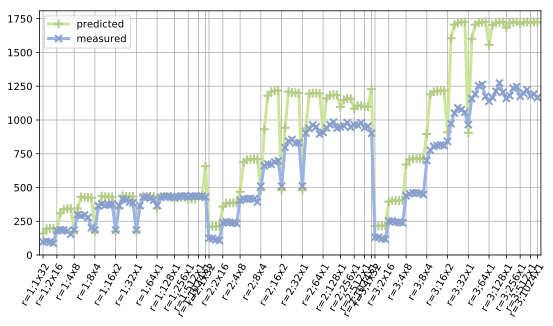

In [35]:
plotComparison(*memdata)

In [9]:
maxOverlapData = compareSeries([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024], [1, 2, 4, 8, 16, 32, 64, 128, 256], [1], overlap=maxOverlap)

r=1, block=1x32
(32, 16, 1)
(1, 32, 1)
(32, 16, 1)
(4, 4, 1)
51.0
32.0
160.0 cycles
10.0390625
8.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       5120   480    5120    72     2604    3947  17271
       5120   120     160    72      213     276   5890
Meas / Pred (GFlop/s): 98 / 173

r=1, block=1x64
(32, 16, 1)
(1, 64, 1)
(32, 16, 1)
(4, 4, 1)
49.5
32.0
160.0 cycles
10.01953125
8.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       5120   960   10240   144     5248    7710  29278
       5120   120    4467    72      224     308  10240
Meas / Pred (GFlop/s): 101 / 199

r=1, block=1x128
(32, 16, 1)
(1, 128, 1)
(32, 16, 1)
(4, 4, 1)
48.75
32.0
160.0 cycles
10.009765625
8.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       2560   960   10240   144     5245    7640  26644
       2560   120    7031    72      224     305  10240
Meas / Pred (GFlop/s): 97 / 199

r=1, block=1x256
(32, 16, 1)
(1, 256, 1)
(32, 16, 1)
(4, 4, 1)
48.375
32.0
160.0 cycles
10.00

9.0703125
8.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       5120   480     640    72     2461    1830  10532
       5120   120      20    72      211     237   5760
Meas / Pred (GFlop/s): 184 / 177

r=1, block=32x2
(32, 16, 1)
(32, 2, 1)
(32, 16, 1)
(4, 4, 1)
20.0
8.0
20.0 cycles
8.56640625
8.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       5120   960    1280   144     4821    2677  14858
       5120   120      20    72      317     237   5866
Meas / Pred (GFlop/s): 366 / 347

r=1, block=32x4
(32, 16, 1)
(32, 4, 1)
(32, 16, 1)
(4, 4, 1)
15.0
8.0
20.0 cycles
8.314453125
8.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       2560   960    1280   144     4747    2207  11753
       2560   120      20    72     1677     237   4666
Meas / Pred (GFlop/s): 429 / 436

r=1, block=32x8
(32, 16, 1)
(32, 8, 1)
(32, 16, 1)
(4, 4, 1)
12.5
8.0
20.0 cycles
8.1884765625
8.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       1280   960    1280   14

In [10]:
randomOverlapData = compareSeries([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024], [1, 2, 4, 8, 16, 32, 64, 128, 256], [1], overlap=randomOverlap)

r=1, block=1x32
(32, 16, 1)
(1, 32, 1)
(32, 16, 1)
(4, 4, 1)
51.0
32.0
160.0 cycles
10.0390625
8.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       5120   480    5120    72     2604    3947  17271
       5120   120     705    72      210     262   6417
Meas / Pred (GFlop/s): 98 / 159

r=1, block=1x64
(32, 16, 1)
(1, 64, 1)
(32, 16, 1)
(4, 4, 1)
49.5
32.0
160.0 cycles
10.01953125
8.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       5120   960   10240   144     5248    7710  29278
       5120   120    4673    72      223     302  10437
Meas / Pred (GFlop/s): 101 / 195

r=1, block=1x128
(32, 16, 1)
(1, 128, 1)
(32, 16, 1)
(4, 4, 1)
48.75
32.0
160.0 cycles
10.009765625
8.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       2560   960   10240   144     5245    7640  26644
       2560   120    7106    72      224     303  10312
Meas / Pred (GFlop/s): 97 / 197

r=1, block=1x256
(32, 16, 1)
(1, 256, 1)
(32, 16, 1)
(4, 4, 1)
48.375
32.0
160.0 cycles
10.00

9.0703125
8.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       5120   480     640    72     2461    1830  10532
       5120   120      22    72      211     237   5760
Meas / Pred (GFlop/s): 184 / 177

r=1, block=32x2
(32, 16, 1)
(32, 2, 1)
(32, 16, 1)
(4, 4, 1)
20.0
8.0
20.0 cycles
8.56640625
8.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       5120   960    1280   144     4821    2677  14858
       5120   120      25    73      317     237   5866
Meas / Pred (GFlop/s): 366 / 347

r=1, block=32x4
(32, 16, 1)
(32, 4, 1)
(32, 16, 1)
(4, 4, 1)
15.0
8.0
20.0 cycles
8.314453125
8.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       2560   960    1280   144     4747    2207  11753
       2560   120      27    73     1676     237   4666
Meas / Pred (GFlop/s): 429 / 436

r=1, block=32x8
(32, 16, 1)
(32, 8, 1)
(32, 16, 1)
(4, 4, 1)
12.5
8.0
20.0 cycles
8.1884765625
8.0
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       1280   960    1280   14

In [11]:
v1Data = randomOverlapData#compareSeries([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024], [1, 2, 4, 8, 16, 32, 64, 128, 256], [1], version=1)

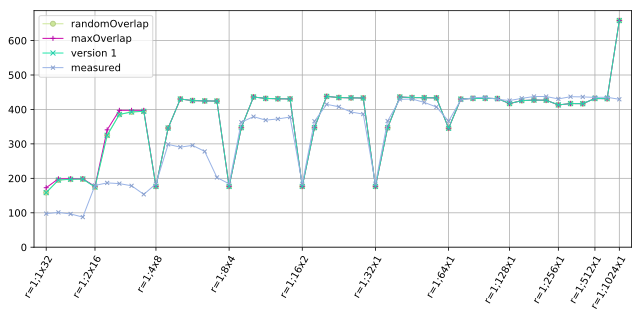

In [12]:
fig, ax = plt.subplots()
fig.set_figwidth(9)
fig.set_figheight(4.5)
fig.set_dpi(200)

ax.plot(randomOverlapData[1], "-o", label="randomOverlap",  color="#CCE699", linewidth=1, markersize=5, markeredgewidth=1, markeredgecolor="#B5CC88")
ax.plot(maxOverlapData[1], "-+", label="maxOverlap",  color="#CC06AA", linewidth=1, markersize=5, markeredgewidth=1, markeredgecolor="#B50CAA")
ax.plot(v1Data[1], "-x", label="version 1",  color="#22E6AA", linewidth=1, markersize=5, markeredgewidth=1, markeredgecolor="#22CCAA")

ax.plot(randomOverlapData[0], "-x", label="measured", color="#99B3E6", linewidth=1, markersize=4, markeredgewidth=1, markeredgecolor="#889FCC")

#ax.set_yscale("log")

ax.set_xticks(randomOverlapData[2])
ax.set_xticklabels( randomOverlapData[3], rotation=60, rotation_mode="anchor", horizontalalignment="right")
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xlim(-1, len(randomOverlapData[0]))

fig.tight_layout()
ax.legend()
ax.grid()
plt.show()